In [36]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

import pandas as pd
from cluster_dtw import *
import matplotlib.pyplot as plt
import json
import pickle

In [37]:
ENDOGENOUS = True
EXOGENOUS = False

POSSIBLE_TARGET = ['urgences', 'hospits']

TARGET = 'hospits'
assert TARGET in ['urgences', 'hospits']

AGE = 'children'
assert AGE in ['adults', 'children', '']

OUTLIERS = True
XOUTLIERS = True
OUTLIERS_PATH = './outliers_etabs.json'

DATA_DIR = '../data/datasets/'

SAVE_DIR = './result_clusters_56/' + TARGET + (f'_{AGE}' if AGE else '') + '/'

TARGET_RAW = True

if TARGET == 'urgences':
    target_column = 'target_hospital_nb_emmergencies%J+3%mean_3J' if not TARGET_RAW else 'hospital_nb_emmergencies'
elif TARGET == 'hospits' and AGE == 'adults':
    target_column = 'target_hospital_nb_hospit_np_from_ED_adults%J+7%mean_7J' if not TARGET_RAW else 'hospital_nb_hospit_np_from_ED_adults'
elif TARGET == 'hospits' and AGE == 'children':
    target_column = 'target_hospital_nb_hospit_np_from_ED_children%J+7%mean_7J' if not TARGET_RAW else 'hospital_nb_hospit_np_from_ED_children'


In [38]:
if SAVE_DIR != None:
    if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR, exist_ok=True)

In [39]:
print(os.listdir(DATA_DIR))

['full_dataset_GROUPEMENT HOSPITALIER DE HAUTE SAONE.csv', 'full_dataset_CH AUXERRE_targets_urgences.csv', 'full_dataset_HÔPITAL PRIVÉ DIJON BOURGOGNE.csv', 'full_dataset_CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE.csv', 'full_dataset_CH COSNE COURS SUR LOIRE_targets_hospits.csv', 'full_dataset_CH LOUIS JAILLON SAINT CLAUDE_targets_hospits.csv', 'full_dataset_POLYCLINIQUE STE MARGUERITE AUXERRE.csv', 'full_dataset_CH CHARTRES.csv', 'full_dataset_CH DECIZE.csv', 'full_dataset_CH J. COEUR BOURGES_targets_urgences.csv', 'full_dataset_CH VENDOME.csv', 'full_dataset_CH CHARTRES_targets_hospits.csv', 'full_dataset_CH JURA SUD_targets_urgences.csv', 'full_dataset_CH LA TOUR BLANCHE ISSOUDUN_targets_urgences.csv', 'full_dataset_CH VENDOME_targets_urgences.csv', "full_dataset_CH D'AVALLON.csv", 'full_dataset_CH VIERZON_targets_hospits.csv', 'full_dataset_CH DU TONNERROIS.csv', 'full_dataset_CH DU VAL DE SAÔNE GRAY_targets_urgences.csv', 'full_dataset_CH LE BLANC.csv', 'full_dataset_CH L PASTEUR

## Functions

In [40]:
def subplots_time_series(time_series, date_range, labels, value='Value', cluster='', save_dir=None):
    plt.figure(figsize=(15, 100))

    # Subplot for ts
    for i in range(len(labels)):
        plt.subplot(len(labels), 1, i+1)
        plt.plot(date_range, time_series[i], label=labels[i], linewidth=0.5)
        title = f'{labels[i]} {value}'
        plt.title(title)
        plt.grid(True)

    plt.tight_layout()
    if save_dir != None: plt.savefig(save_dir + f"subplots_{value}{cluster}.png", format="png", dpi=300)
    plt.show()

## Loading Data

In [41]:
if not OUTLIERS or XOUTLIERS:
    # read json file
    outlier_dic = json.load(open(OUTLIERS_PATH))
    outlier_list = outlier_dic[TARGET + (f'_{AGE}' if AGE else '')]
    # for target in outlier_dic.keys():
    #     for etab in outlier_dic[target]:
    #         if etab not in outlier_list:
    #             outlier_list.append(etab)

In [42]:
len(outlier_list)

46

In [43]:
datasets = []
etabs = []
for file in os.listdir(DATA_DIR):
    condition = (file.endswith(TARGET + ".csv") if not TARGET_RAW else not 'target' in file)
    if condition:
        # print(file)
        etab = file.split("_")[2][:-4]
        if not OUTLIERS and etab in outlier_list: continue
        if XOUTLIERS and etab not in outlier_list: continue
        etabs.append(etab)
        df = pd.read_csv(os.path.join(DATA_DIR, file))
        if not EXOGENOUS: df = df[['date', target_column]]
        df.set_index('date', inplace=True)
        # print(f'{etabs[-1]} : {df.shape}')
        datasets.append(df)

In [44]:
datasets[0]

,hospital_nb_hospit_np_from_ED_children
date,
2019-01-03,0
2019-01-04,0
2019-01-05,0
2019-01-06,0
2019-01-07,0
...,...
2023-12-27,0
2023-12-28,0
2023-12-29,0


In [45]:
start_date = datasets[0].index.min()
end_date = datasets[0].index.max()
date_range = pd.date_range(start_date, end_date)

In [46]:
for etab in etabs:
    print(etab)

GROUPEMENT HOSPITALIER DE HAUTE SAONE
HÔPITAL PRIVÉ DIJON BOURGOGNE
CLINIQUE MÉDICO-CHIRURGICALE DE CHENOVE
POLYCLINIQUE STE MARGUERITE AUXERRE
CH CHARTRES
CH DECIZE
CH VENDOME
CH D'AVALLON
CH DU TONNERROIS
CH LE BLANC
CH LA TOUR BLANCHE ISSOUDUN
CH LOUIS JAILLON SAINT CLAUDE
SAS NOUVELLE CLINIQUE DE TOURS +
CH L PASTEUR DOLE
CH ST AMAND MONTROND
CH ROMORANTIN LANTHENAY
CH DE LA HAUTE COTE-D'OR - CH-HCO
CH JEAN BOUVERI - GALUZOT
HOSPICES CIVILS DE BEAUNE
CH AUTUN
CH DE CLAMECY
CH DE CHATEAUROUX
CHR ORLEANS
CH CHINONAIS
CHIC AMBOISE- CHATEAU RENAULT
CH DE CHATEAUDUN
CH VICTOR JOUSSELIN
CH DE PITHIVIERS
CH DE BLOIS
ORELIANCE - REINE BLANCHE
CH AGGLOMERATION MONTARGOISE
CH LEON BERARD MOREZ
HÔPITAL PRIVÉ D'EURE ET LOIR
CH DE NOGENT LE ROTROU
CH ROBERT MORLEVAT SEMUR EN AUXOIS
CH DU PAYS CHAROLAIS BRIONNAIS
CH COSNE COURS SUR LOIRE
CH DE GIEN
CH DU VAL DE SAÔNE GRAY
CH VIERZON
HOTEL-DIEU DU CREUSOT
CH LOCHES
CHIC DE HAUTE-COMTÉ
PÔLE SANTÉ LÉONARD DE VINCI
CH DE JOIGNY
CH J. COEUR

In [47]:
len(etabs)

46

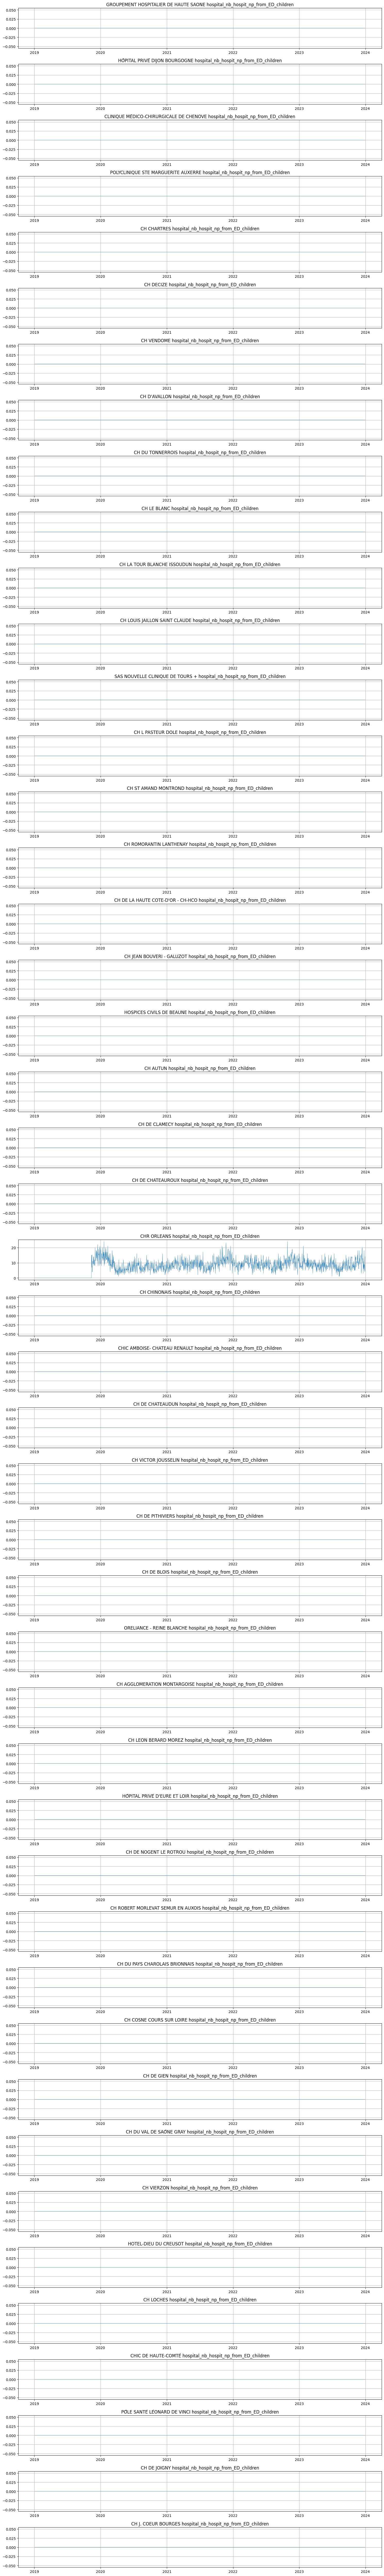

In [48]:
ts = []
tag = '_outliers'
for etab in etabs:
    ts.append(datasets[etabs.index(etab)][target_column])
subplots_time_series(ts, date_range, etabs, value=target_column, cluster=tag, save_dir=SAVE_DIR)

In [49]:
len(ts)

46